In [ ]:
!pip install ultralytics

In [ ]:
import pickle
import torch
import numpy as np
from torchvision.ops import nms
from PIL import Image
from torchvision.transforms import functional as F
from collections import namedtuple
from ultralytics import YOLO
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.metrics import precision_score, recall_score, f1_score
from collections import defaultdict

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Confidence threshold (50%)
CONFIDENCE_THRESHOLD = 0.5

# Define the device (CPU/GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

EnsembleModel = namedtuple('EnsembleModel', ['fasterrcnn_model', 'yolo_model', 'class_mappings'])

try:
    with open('/content/drive/MyDrive/minorproject/ensemble_model.pkl', 'rb') as f:
        ensemble_model = pickle.load(f)
    print("Model loaded successfully!")
except Exception as e:
    print(f"Error loading model: {e}")
    raise

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model loaded successfully!


In [ ]:
# Extract components
fasterrcnn_model = ensemble_model.fasterrcnn_model.to(device)
yolo_model = ensemble_model.yolo_model
class_mappings = ensemble_model.class_mappings

# Prepare image tensor
def prepare_image(image_path):
    image = Image.open(image_path).convert("RGB")
    return F.to_tensor(image).unsqueeze(0).to(device)

# Run YOLO predictions with confidence threshold
def run_yolo_predictions(image_path):
    results = yolo_model.predict(source=image_path, conf=CONFIDENCE_THRESHOLD)  # Apply threshold here
    boxes = results[0].boxes.xyxy.cpu().numpy()
    scores = results[0].boxes.conf.cpu().numpy()
    labels = [class_mappings['YOLO_CLASSES'][int(label)] for label in results[0].boxes.cls.cpu().numpy()]
    return boxes, scores, labels

# NMS-based Fusion with confidence threshold
def nms_fusion(fasterrcnn_preds, yolo_preds, iou_thresh=0.5):
    # Filter Faster R-CNN predictions by confidence
    f_mask = fasterrcnn_preds[0]['scores'] > CONFIDENCE_THRESHOLD
    f_boxes = fasterrcnn_preds[0]['boxes'][f_mask].cpu().numpy()
    f_scores = fasterrcnn_preds[0]['scores'][f_mask].cpu().numpy()
    f_labels = fasterrcnn_preds[0]['labels'][f_mask].cpu().numpy()

    # YOLO predictions already filtered by confidence
    y_boxes, y_scores, y_labels = yolo_preds
    y_label_ids = [class_mappings['CLASS_NAME_TO_ID'][label] for label in y_labels]

    # Combine predictions
    boxes = np.vstack([f_boxes, y_boxes])
    scores = np.hstack([f_scores, y_scores])
    labels = np.hstack([f_labels, y_label_ids])

    # Apply NMS
    keep = nms(
        torch.tensor(boxes, dtype=torch.float32),
        torch.tensor(scores, dtype=torch.float32),
        iou_thresh
    )

    # Filter final results by confidence again (in case NMS changed order)
    final_boxes = boxes[keep]
    final_scores = scores[keep]
    final_labels = labels[keep]

    # Apply confidence threshold to final results
    conf_mask = final_scores > CONFIDENCE_THRESHOLD
    return final_boxes[conf_mask], final_scores[conf_mask], final_labels[conf_mask]

# Visualization function (only shows detections above threshold)
def visualize(image_path, boxes, labels, scores, title):
    img = Image.open(image_path)
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(img)

    for box, label, score in zip(boxes, labels, scores):
        if score < CONFIDENCE_THRESHOLD:
            continue  # Skip low-confidence detections
        x1, y1, x2, y2 = box
        rect = patches.Rectangle(
            (x1, y1), x2-x1, y2-y1,
            linewidth=2, edgecolor='r', facecolor='none'
        )
        ax.add_patch(rect)
        ax.text(
            x1, y1,
            f"{class_mappings['COCO_CLASSES'][label]} {score:.2f}",
            color='r', fontsize=12, bbox=dict(facecolor='white', alpha=0.7)
        )
    ax.set_title(title)
    plt.axis('off')
    plt.show()

def calculate_model_agreement(frcnn_preds, yolo_preds):
    """Calculate agreement metrics between the two models"""
    # Filter Faster R-CNN predictions by confidence
    f_mask = frcnn_preds[0]['scores'] > CONFIDENCE_THRESHOLD
    frcnn_items = [class_mappings['COCO_CLASSES'][l] for l in frcnn_preds[0]['labels'][f_mask].cpu().numpy()]
    frcnn_items = list(set(frcnn_items))  # Get unique items

    # YOLO predictions already filtered by confidence
    yolo_items = list(set([class_mappings['CLASS_NAME_TO_ID'][l] for l in yolo_preds[2]]))
    yolo_items = [class_mappings['COCO_CLASSES'][l] for l in yolo_items]

    # Calculate Jaccard Index (Intersection over Union)
    intersection = len(set(frcnn_items) & set(yolo_items))
    union = len(set(frcnn_items) | set(yolo_items))
    jaccard_index = intersection / union if union > 0 else 0

    # Calculate agreement percentage
    total_predictions = len(frcnn_items) + len(yolo_items)
    agreement = (2 * intersection) / total_predictions if total_predictions > 0 else 0

    return {
        'jaccard_index': jaccard_index,
        'agreement_percentage': agreement,
        'frcnn_unique': frcnn_items,
        'yolo_unique': yolo_items,
        'common_items': list(set(frcnn_items) & set(yolo_items))
    }

def calculate_confidence_metrics(scores):
    """Calculate statistics based on confidence scores (only for detections above threshold)"""
    high_conf_scores = [s for s in scores if s >= CONFIDENCE_THRESHOLD]

    if len(high_conf_scores) == 0:
        return {
            'mean_confidence': 0,
            'high_confidence_ratio': 0,
            'confidence_std': 0,
            'min_confidence': 0,
            'max_confidence': 0,
            'num_detections': 0
        }

    return {
        'mean_confidence': np.mean(high_conf_scores),
        'high_confidence_ratio': len(high_conf_scores)/len(scores) if len(scores) > 0 else 0,
        'confidence_std': np.std(high_conf_scores),
        'min_confidence': min(high_conf_scores),
        'max_confidence': max(high_conf_scores),
        'num_detections': len(high_conf_scores)
    }

# Main detection function
def detect_ingredients(image_path):
    # Get predictions
    img_tensor = prepare_image(image_path)

    with torch.no_grad():
        frcnn_preds = fasterrcnn_model(img_tensor)

    yolo_preds = run_yolo_predictions(image_path)

    # Fuse predictions
    boxes, scores, labels = nms_fusion(frcnn_preds, yolo_preds)

    # Get readable results (only those above confidence threshold)
    detected = [class_mappings['COCO_CLASSES'][l] for l in labels]
    unique = list(set(detected))

    # Visualize (only shows detections above threshold)
    visualize(image_path, boxes, labels, scores, f"Detected Ingredients (Confidence > {CONFIDENCE_THRESHOLD})")

    # Calculate model agreement metrics (only considers high-confidence detections)
    agreement_metrics = calculate_model_agreement(frcnn_preds, yolo_preds)

    # Calculate confidence metrics (only for high-confidence detections)
    confidence_metrics = calculate_confidence_metrics(scores)

    return {
        'detected_items': detected,
        'unique_items': unique,
        'boxes': boxes.tolist(),
        'scores': scores.tolist(),
        'model_agreement': agreement_metrics,
        'confidence_metrics': confidence_metrics
    }


image 1/1 /content/drive/MyDrive/minorproject/test.webp: 480x640 1 tomato, 3 onions, 21.8ms
Speed: 3.8ms preprocess, 21.8ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 640)


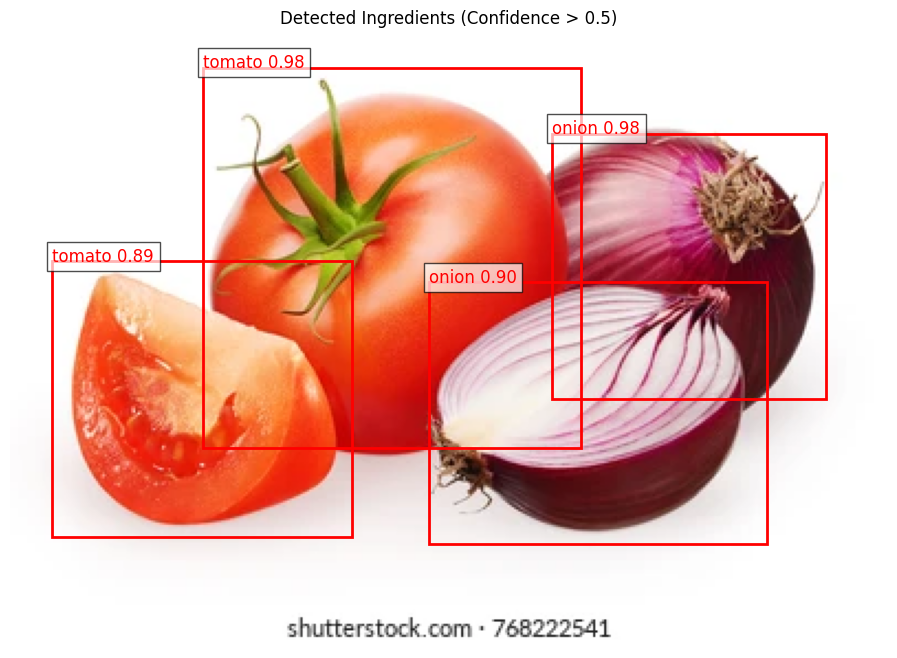


Detection Results (Confidence > 0.5):
All items: ['tomato', 'onion', 'onion', 'tomato']
Unique items: ['onion', 'tomato']
Confidence scores: ['0.98', '0.98', '0.90', '0.89']

Model Agreement Metrics (High-confidence detections only):
Jaccard Index (similarity): 1.00
Agreement Percentage: 1.00
Faster R-CNN detected: ['onion', 'tomato']
YOLO detected: ['tomato', 'onion']
Common items: ['onion', 'tomato']

Confidence Metrics (Only detections > 0.5):
Number of detections: 4
Mean confidence: 0.94
High confidence ratio: 1.00
Confidence std: 0.04
Min confidence: 0.89
Max confidence: 0.98


In [ ]:
if __name__ == "__main__":
    test_image = "/content/drive/MyDrive/minorproject/test.webp"  # Replace with your image
    results = detect_ingredients(test_image)

    print("\nDetection Results (Confidence > 0.5):")
    print(f"All items: {results['detected_items']}")
    print(f"Unique items: {results['unique_items']}")
    print(f"Confidence scores: {[f'{s:.2f}' for s in results['scores']]}")

    # Print agreement metrics
    print("\nModel Agreement Metrics (High-confidence detections only):")
    print(f"Jaccard Index (similarity): {results['model_agreement']['jaccard_index']:.2f}")
    print(f"Agreement Percentage: {results['model_agreement']['agreement_percentage']:.2f}")
    print(f"Faster R-CNN detected: {results['model_agreement']['frcnn_unique']}")
    print(f"YOLO detected: {results['model_agreement']['yolo_unique']}")
    print(f"Common items: {results['model_agreement']['common_items']}")

    # Print confidence metrics
    print("\nConfidence Metrics (Only detections > 0.5):")
    print(f"Number of detections: {results['confidence_metrics']['num_detections']}")
    print(f"Mean confidence: {results['confidence_metrics']['mean_confidence']:.2f}")
    print(f"High confidence ratio: {results['confidence_metrics']['high_confidence_ratio']:.2f}")
    print(f"Confidence std: {results['confidence_metrics']['confidence_std']:.2f}")
    print(f"Min confidence: {results['confidence_metrics']['min_confidence']:.2f}")
    print(f"Max confidence: {results['confidence_metrics']['max_confidence']:.2f}")